## Solve for Vehicle Routing Problem (VRP) / Traveling Salesman Problem (TSP)

In [26]:
%pip install ortools ipyleaflet geopandas pyproj shapely

Note: you may need to restart the kernel to use updated packages.


## 1. Naive TSP solver

- Setup Params
- Load Files
- Run TSP Solver with Google OR
- Visualize on ipyleaflet

In [27]:
# Params
site_path = "sample_data3/"  # *CHANGE HERE* for different sample data
img_path = site_path + "random_oilpalm.tif"
crowns_path = site_path + "crowns_exported.gpkg"
overlay_img_path = site_path + "overlay_rgb.png"

# Home/origin location (lat, lon)
# home = (1.954826, 103.214203) # sample 1
# home = (1.426639, 103.644381) # sample 2
home = (1.523838, 103.842520) # sample 3

# List of crown IDs to visit
visit_ids = [20, 21, 25, 26, 27]

# Drone parameters
drone_speed = 1.5        # meters per second
max_flight_time = 480.0  # seconds
max_distance = drone_speed * max_flight_time  # meters

In [28]:
# File I/O
import rasterio
import asyncio
import geopandas as gpd
import numpy as np
from shapely.geometry import box, mapping, shape
from shapely.ops import transform
import pyproj
from pyproj import Geod
from PIL import Image
from ipyleaflet import (
    Map, GeoJSON, Marker, Popup, LayerGroup, DivIcon, AwesomeIcon, Icon,
    basemap_to_tiles, basemaps, ImageOverlay, LayersControl, TileLayer,
    WidgetControl, MarkerCluster, Polyline
)
from ipywidgets import HTML, Layout, Button
# --- Save RGB overlay as PNG from GeoTIFF ---
def save_rgb_overlay_as_png(img_path, output_img="overlay.png"):
    with rasterio.open(img_path) as src:
        img = src.read()
        bounds = src.bounds
        crs = src.crs
        
        if img.shape[0] >= 3:
            rgb = np.stack([img[0], img[1], img[2]], axis=-1)
        else:
            raise ValueError("Need at least 3 bands for RGB")
        
        # Normalize for better display
        rgb = rgb.astype(np.float32)
        rgb_min, rgb_max = np.percentile(rgb[rgb > 0], (2, 98))
        rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)
        rgb = (rgb * 255).astype(np.uint8)
        
        image = Image.fromarray(rgb)
        image.save(output_img)
        
        return output_img, bounds, crs

overlay_img_path, utm_bounds, utm_crs = save_rgb_overlay_as_png(img_path, output_img=overlay_img_path)

# --- Convert UTM bounds to WGS84 ---
def reproject_bounds_to_wgs84(bounds, src_crs):
    project = pyproj.Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True).transform
    return transform(project, box(*bounds)).bounds

wgs84_bounds = reproject_bounds_to_wgs84(utm_bounds, utm_crs)
lon_min, lat_min, lon_max, lat_max = wgs84_bounds

# --- Load crowns and reproject to WGS84 ---
crowns = gpd.read_file(crowns_path)
if crowns.crs != "EPSG:4326":
    crowns = crowns.to_crs("EPSG:4326")

In [29]:
# Solver
import numpy as np
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from pyproj import Transformer

# --- 1. Load crowns and extract coordinates ---
coords = {}
for idx, row in crowns.iterrows():
    # Extract centroid coordinates from the polygon
    coords[idx] = (row.geometry.centroid.y, row.geometry.centroid.x)

# Build ordered list of nodes: home=0, then each visit_id
node_ids = [0] + visit_ids  # 0 represents home
node_coords = {0: home}     # Add home coordinates as node 0

# Add coordinates for visit points
for vid in visit_ids:
    if vid in coords:
        node_coords[vid] = coords[vid]
    else:
        print(f"Warning: ID {vid} not found in coordinates dictionary")
        
# --- 2. Compute distance matrix (UTM -> Euclidean in meters) ---
# Transformer to UTM (choose zone automatically)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)  # Web Mercator
n = len(node_ids)
dist_matrix = np.zeros((n, n), dtype=int)
for i, id_i in enumerate(node_ids):
    x_i, y_i = transformer.transform(node_coords[id_i][1], node_coords[id_i][0])
    for j, id_j in enumerate(node_ids):
        x_j, y_j = transformer.transform(node_coords[id_j][1], node_coords[id_j][0])
        dist_matrix[i, j] = int(np.hypot(x_i - x_j, y_i - y_j))

print(dist_matrix)

# --- 3. Set up OR-Tools routing for Orienteering ---
manager = pywrapcp.RoutingIndexManager(
    len(dist_matrix), # number of nodes
    1,                # number of vehicles
    0                 # home node index
)
routing = pywrapcp.RoutingModel(manager)

# Distance callback
def distance_callback(i, j):
    return dist_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
transit_cb = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_cb)

# Add distance dimension with cap
routing.AddDimension(
    transit_cb,
    slack_max=0,
    capacity=int(max_distance),
    fix_start_cumul_to_zero=True,
    name='Distance'
)

# Allow dropping nodes with penalty (1 per node)
penalty = 1000  # cost for skipping a node
for node in range(1, n):
    routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

# Search parameters
search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
search_params.time_limit.seconds = 10

solution = routing.SolveWithParameters(search_params)

# --- 4. Extract the optimized route ---
route_ids = []
if solution:
    idx = routing.Start(0)
    while not routing.IsEnd(idx):
        node = manager.IndexToNode(idx)
        route_ids.append(node_ids[node])
        idx = solution.Value(routing.NextVar(idx))
    route_ids.append(node_ids[manager.IndexToNode(idx)])  # return home
    total_dist = solution.ObjectiveValue()
    print("Optimized route (in visit order):", route_ids)
    print(f"Total distance: {total_dist} m  (max allowed {max_distance} m)")
else:
    print("No feasible route found within flight time.")

[[ 0 38 31 17 12 17]
 [38  0  9 33 40 24]
 [31  9  0 24 32 15]
 [17 33 24  0  9  9]
 [12 40 32  9  0 16]
 [17 24 15  9 16  0]]
Optimized route (in visit order): [0, 26, 25, 27, 21, 20, 0]
Total distance: 92 m  (max allowed 720.0 m)


In [30]:
# visualize

crowns["id"] = crowns.index
crowns_json = crowns.__geo_interface__

for i, feat in enumerate(crowns_json["features"]):
    feat["id"] = i

center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

m = Map(center=(center_lat, center_lon), zoom=18, max_zoom=20)
m.layout.width = '100%'
m.layout.height = '900px'

google_sat = TileLayer(
    url="http://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attribution="Google Satellite",
    name="Google Satellite",
    max_zoom=20
)
m.add_layer(google_sat)

esri_sat = basemap_to_tiles(basemaps.Esri.WorldImagery)
esri_sat.name = "ESRI Imagery"
m.add_layer(esri_sat)

overlay = ImageOverlay(
    url=overlay_img_path,
    bounds=[(lat_min, lon_min), (lat_max, lon_max)],
    opacity=0.6,
    name="Oil Palm RGB"
)
m.add_layer(overlay)

m.add_control(LayersControl(position="topright"))

debug_output = HTML(
    value="Debug info will appear here and in console",
    layout=Layout(width='100%', height='50px', border='1px solid gray', padding='5px')
)

crown_id_layer = LayerGroup(name="Crown IDs")
m.add_layer(crown_id_layer)

for feature in crowns_json['features']:
    crown_id = feature['id']
    geometry = feature['geometry']
    if geometry['type'] == 'Polygon':
        polygon = shape(geometry)
        centroid = polygon.centroid
        icon = DivIcon(
                icon_size=(20, 20),
                icon_anchor=(10, 10),
            )
        if crown_id in route_ids:
            if crown_id == route_ids[-1]:
                icon.html = f"<div style='color: #ffffff; font-size: 12px; text-align: center; text-shadow: -1px -1px 0 black, 1px -1px 0 black, -1px 1px 0 black, 1px 1px 0 black;'>{crown_id}</div>"
            else:
                icon.html=f"<div style='color: darkblue; font-size: 12px; font-weight: bold; text-align: center; text-shadow: -1px -1px 0 blue, 1px -1px 0 blue, -1px 1px 0 blue, 1px 1px 0 blue;'>{crown_id}</div>"
        else:
            icon.html = f"<div style='color: #ffffff; font-size: 12px; text-align: center; text-shadow: -1px -1px 0 black, 1px -1px 0 black, -1px 1px 0 black, 1px 1px 0 black;'>{crown_id}</div>"
        marker = Marker(location=(centroid.y, centroid.x), icon=icon, draggable=False)
        crown_id_layer.add_layer(marker)

# marker_layer = MarkerCluster(name="Crown Id")
# m.add_layer(marker_layer)

crown_layer = GeoJSON(
    data=crowns_json,
    name="Tree Crowns",
    hover_style={"fillColor": "red", "fillOpacity": 0.5},
    style={"fillOpacity": 0.3, "color": "yellow", "weight": 0.5},
    click_events=True 
)

m.add_layer(crown_layer)

frame_delay = 0.1  # seconds per frame
speed_up_factor = 5.0
step_distance = drone_speed * frame_delay * speed_up_factor

route_coords = [node_coords[vid] for vid in route_ids]

def interpolate_segment(p1, p2, step_dist):
    """
    Returns a list of interpolated points between p1 and p2 using step_dist spacing.
    """
    geod = Geod(ellps="WGS84")
    lon1, lat1 = p1[1], p1[0]
    lon2, lat2 = p2[1], p2[0]
    az12, az21, total_dist = geod.inv(lon1, lat1, lon2, lat2)
    
    n_steps = max(int(total_dist // step_dist), 1)
    interpolated_points = []
    
    for i in range(n_steps + 1):
        dist = (i / n_steps) * total_dist
        lon, lat, _ = geod.fwd(lon1, lat1, az12, dist)
        interpolated_points.append((lat, lon))
    
    return interpolated_points

def generate_interpolated_route(route_coords, step_dist=2.0):
    full_route = []
    for i in range(len(route_coords) - 1):
        segment = interpolate_segment(route_coords[i], route_coords[i+1], step_dist)
        # Avoid duplicating points
        if i > 0:
            segment = segment[1:]
        full_route.extend(segment)
    return full_route

smooth_route = generate_interpolated_route(route_coords, step_dist=step_distance)
print("Interpolated route length:", len(smooth_route))
print("Interpolated route coordinates:", smooth_route)

quad_icon = AwesomeIcon(
    name='fighter-jet',
    marker_color="black",
    icon_color='white',
    icon_size=[30, 30],
    icon_anchor=[15, 15]
)

animated_marker = Marker(location=route_coords[0], icon=quad_icon)
animated_line = Polyline(locations=[route_coords[0]], color="cyan", fill=False, weight=4)

animation_layer = LayerGroup(name="Drone Route")
animation_layer.add_layer(animated_marker)
animation_layer.add_layer(animated_line)
m.add_layer(animation_layer)

async def animate_route(marker, polyline, route, delay=0.1):
    for coord in route[1:]:
        await asyncio.sleep(delay)
        marker.location = coord
        polyline.locations = polyline.locations + [coord]

start_button = Button(
    description="Start Drone Animation",
    layout=Layout(width='220px', height='40px', margin='10px 0px 10px 10px'),
    style={'button_color': "#1fb49b", 'font_weight': 'bold', 'font_size': '14px'}
)

def on_start_click(b):
    start_button.disabled = False
    loop = asyncio.get_event_loop()
    loop.create_task(animate_route(animated_marker, animated_line, smooth_route, delay=frame_delay))

start_button.on_click(on_start_click)


display(m)
display(start_button)

Interpolated route length: 124
Interpolated route coordinates: [(1.523838, 103.84252), (1.523831251996124, 103.8425213786766), (1.5238245039922464, 103.8425227573532), (1.5238177559883679, 103.8425241360298), (1.523811007984488, 103.84252551470637), (1.523804259980606, 103.84252689338294), (1.5237975119767235, 103.84252827205951), (1.5237907639728396, 103.84252965073607), (1.523784015968954, 103.84253102941261), (1.5237772679650678, 103.84253240808914), (1.5237705199611797, 103.84253378676567), (1.5237637719572907, 103.8425351654422), (1.5237570239534, 103.84253654411872), (1.5237502759495083, 103.84253792279522), (1.5237435279456144, 103.84253930147172), (1.5237367799417207, 103.8425406801482), (1.5237300319378244, 103.84254205882468), (1.5237291939219606, 103.84254925192357), (1.5237283559060728, 103.84255644502245), (1.5237275178901608, 103.84256363812133), (1.5237266798742244, 103.84257083122021), (1.5237258418582642, 103.8425780243191), (1.5237250038422798, 103.84258521741796), (1

Map(center=[1.5240548772462368, 103.8422855317323], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Button(description='Start Drone Animation', layout=Layout(height='40px', margin='10px 0px 10px 10px', width='2…

## 2. Create occupancy grid

In [31]:
# Params
site_path = "sample_data3/" # *CHANGE HERE* for different sample data
img_path = site_path + "random_oilpalm.tif"
crowns_path = site_path + "crowns_exported.gpkg"
overlay_img_path = site_path + "overlay_rgb.png"
occupancy_img_path = site_path + "occupancy_map.png"
occupancy_resolution = 0.1 # in m
vehicle_radius = 0.3 # in m
palm_oil_tree_radius = 0.5 # in m
orbital_radius = 1.0 # in m
inflated_obstacle = (vehicle_radius + palm_oil_tree_radius) * 2 + orbital_radius

In [32]:
# Generate occupancy map
import rasterio
import geopandas as gpd
import numpy as np
from shapely.geometry import box, shape
from rasterio.features import rasterize
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject
import pyproj
from ipyleaflet import (
    Map, GeoJSON, Marker, LayerGroup, DivIcon,
    basemap_to_tiles, ImageOverlay, LayersControl, TileLayer, Polyline
)
from ipywidgets import Layout
from PIL import Image
from IPython.display import display

def save_rgb_overlay_as_png(img_path, output_img):
    with rasterio.open(img_path) as src:
        img = src.read()
        bounds = src.bounds
        crs = src.crs
        
        if img.shape[0] >= 3:
            rgb_bands = [img[i] for i in range(3)]
        elif img.shape[0] == 1: # Grayscale
             rgb_bands = [img[0]] * 3
        else: # Not enough bands
            raise ValueError(f"Image has {img.shape[0]} bands, expected at least 1 (for grayscale) or 3 (for RGB).")

        rgb = np.stack(rgb_bands, axis=-1).astype(np.float32)
        
        nodata = src.nodata
        if nodata is not None:
            mask = np.all(rgb == nodata, axis=-1) if rgb.ndim == 3 and rgb.shape[-1] == len(str(nodata)) else rgb == nodata
            valid_pixels = rgb[~mask]
        else:
            valid_pixels = rgb[rgb > 0] # Fallback if no specific nodata, assuming 0 might be invalid

        if valid_pixels.size == 0:
            rgb_min, rgb_max = 0, 255
        else:
            rgb_min, rgb_max = np.percentile(valid_pixels, (2, 98))

        if rgb_max - rgb_min == 0:
            rgb_norm = np.zeros_like(rgb, dtype=np.float32)
        else:
            rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min)
            
        rgb_clipped = np.clip(rgb_norm, 0, 1)
        rgb_uint8 = (rgb_clipped * 255).astype(np.uint8)
        
        # Handle alpha if original image had it and was preserved, or create if needed
        if img.shape[0] == 4 and rgb_uint8.shape[-1] == 3: 
            alpha_band = img[3]
            # Normalize alpha if it's not already uint8
            if alpha_band.dtype != np.uint8:
                alpha_band = (np.clip(alpha_band / np.max(alpha_band) if np.max(alpha_band) > 0 else 0, 0, 1) * 255).astype(np.uint8)
            final_img_data = np.dstack((rgb_uint8, alpha_band))
            pil_mode = 'RGBA'
        else:
            final_img_data = rgb_uint8
            pil_mode = 'RGB'

        Image.fromarray(final_img_data, mode=pil_mode).save(output_img)
        return output_img, bounds, crs

def reproject_bounds(bounds, src_crs, dst_crs="EPSG:4326"):
    if not isinstance(src_crs, pyproj.CRS):
        src_crs = pyproj.CRS.from_user_input(src_crs)
    if not isinstance(dst_crs, pyproj.CRS):
        dst_crs = pyproj.CRS.from_user_input(dst_crs)
    transformer = pyproj.Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    return transformer.transform_bounds(bounds.left, bounds.bottom, bounds.right, bounds.top)

overlay_img_path, utm_bounds, utm_crs = save_rgb_overlay_as_png(img_path, overlay_img_path)
wgs84_bounds = reproject_bounds(utm_bounds, utm_crs)
lon_min, lat_min, lon_max, lat_max = wgs84_bounds

with rasterio.open(img_path) as src:
    img_bounds = src.bounds
    width = int(np.ceil((img_bounds.right - img_bounds.left) / occupancy_resolution))
    height = int(np.ceil((img_bounds.top - img_bounds.bottom) / occupancy_resolution))
    transform = from_origin(img_bounds.left, img_bounds.top, occupancy_resolution, occupancy_resolution)

crowns = gpd.read_file(crowns_path).to_crs(utm_crs)

buffered_crowns = []
if not crowns.empty:
    for geom in crowns.geometry:
        if geom is not None and not geom.is_empty:
            center = geom.centroid
            if center is not None and not center.is_empty:
                buffered_crowns.append(center.buffer(inflated_obstacle))

if buffered_crowns:
    shapes_for_rasterize = ((geom, 0) for geom in buffered_crowns if geom is not None)
    occupancy = rasterize(
        shapes=shapes_for_rasterize,
        out_shape=(height, width),
        transform=transform,
        fill=255,
        dtype=np.uint8,
        all_touched=True
    )
else:
    occupancy = np.full((height, width), 255, dtype=np.uint8)

occupancy[0, :] = 0
occupancy[-1, :] = 0
occupancy[:, 0] = 0
occupancy[:, -1] = 0
print(f"Occupancy map shape: {occupancy.shape}")

occupancy_img = Image.fromarray(occupancy)
occupancy_img.save(occupancy_img_path)

crowns_viz = gpd.read_file(crowns_path).to_crs("EPSG:4326")
crowns_viz["id"] = crowns_viz.index
crowns_json = crowns_viz.__geo_interface__
for i, feat in enumerate(crowns_json["features"]):
    feat["id"] = i

center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

m = Map(center=(center_lat, center_lon), zoom=18, max_zoom=20, layout=Layout(width='100%', height='900px'))
m.add_layer(TileLayer(url="http://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}", name="Google Satellite", max_zoom=20))

m.add_layer(ImageOverlay(
    url=overlay_img_path,
    bounds=[(lat_min, lon_min), (lat_max, lon_max)],
    opacity=0.6,
    name="Oil Palm RGB"
))

m.add_layer(ImageOverlay(
    url=occupancy_img_path,
    bounds=[(lat_min, lon_min), (lat_max, lon_max)],
    opacity=0.3,
    name="Occupancy Map"
))

label_layer = LayerGroup(name="Crown IDs")
m.add_layer(label_layer)
if 'features' in crowns_json:
    for feature in crowns_json['features']:
        geom_shape = shape(feature['geometry'])
        if geom_shape.is_empty or not geom_shape.is_valid:
            continue
        c = geom_shape.centroid
        icon = DivIcon(icon_size=(20, 20), icon_anchor=(10, 10),
                      html=f"<div style='color:white;font-size:12px;font-weight:bold;text-align:center;text-shadow:-1px -1px 0 black,1px -1px 0 black,-1px 1px 0 black,1px 1px 0 black;'>{feature.get('id', '')}</div>")
        label_layer.add_layer(Marker(location=(c.y, c.x), icon=icon))

crown_layer = GeoJSON(data=crowns_json, name="Tree Crowns",
                     hover_style={"fillColor": "red", "fillOpacity": 0.5},
                     style={"fillOpacity": 0.3, "color": "yellow", "weight": 0.5})
m.add_layer(crown_layer)

def create_grid_lines(bounds, spacing_deg=0.00001):
    lon_min_grid, lat_min_grid, lon_max_grid, lat_max_grid = bounds
    lines = []
    lons = np.arange(lon_min_grid, lon_max_grid, spacing_deg)
    lats = np.arange(lat_min_grid, lat_max_grid, spacing_deg)
    for lon_val in lons:
        lines.append(Polyline(locations=[(lat_min_grid, lon_val), (lat_max_grid, lon_val)], color="gray", fill=False, opacity=0.3, weight=1))
    for lat_val in lats:
        lines.append(Polyline(locations=[(lat_val, lon_min_grid), (lat_val, lon_max_grid)], color="gray", fill=False, opacity=0.3, weight=1))
    return lines

grid_layer = LayerGroup(name="Grid Lines")
for line in create_grid_lines(wgs84_bounds, spacing_deg=0.00001):
    grid_layer.add_layer(line)
m.add_layer(grid_layer)

m.add_control(LayersControl(position="topright"))
display(m)

Occupancy map shape: (955, 1689)


Map(center=[1.5240548772462368, 103.8422855317323], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## 3. TSP with A*

In [33]:
import math
import heapq
import numpy as np
import rasterio
from rasterio.transform import from_bounds
import matplotlib.pyplot as plt
import geopandas as gpd
from PIL import Image
import pyproj
from shapely.geometry import box
from shapely.ops import transform
from rasterio.crs import CRS
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# Simplified Node class for 2D grid
class Node:
    def __init__(self, x, y, idx=None):
        self.x = x
        self.y = y
        self.idx = idx
        self.g_cost = float('inf')
        self.h_cost = 0
        self.f_cost = float('inf')
        self.parent = None
        
    def __lt__(self, other):
        return self.f_cost < other.f_cost
        
    def __eq__(self, other):
        if other is None:
            return False
        return (self.x == other.x) and (self.y == other.y)
        
    def __hash__(self):
        return hash((self.x, self.y))

class OccupancyMapGeoreferencer:
    """Class to handle georeferencing and coordinate transformations for path planning"""
    
    def __init__(self, occupancy_grid, bounds, crs):
        self.occupancy_grid = occupancy_grid
        self.bounds = bounds
        self.crs = crs
        self.height, self.width = occupancy_grid.shape
        
        # Create affine transformation matrix
        self.transform_matrix = from_bounds(*bounds, self.width, self.height)
        
        # Calculate pixel resolution
        self.pixel_width = (bounds[2] - bounds[0]) / self.width
        self.pixel_height = (bounds[3] - bounds[1]) / self.height
        
        print(f"Occupancy map georeferenced:")
        print(f"  - Grid size: {self.width} x {self.height}")
        print(f"  - Pixel resolution: {self.pixel_width:.3f} x {self.pixel_height:.3f}")
        print(f"  - Bounds: {bounds}")
        print(f"  - CRS: {crs}")
    
    def world_to_pixel(self, x, y):
        col = int((x - self.bounds[0]) / self.pixel_width)
        row = int((self.bounds[3] - y) / self.pixel_height)  # Flip Y axis
        
        # Clamp to grid boundaries
        col = max(0, min(col, self.width - 1))
        row = max(0, min(row, self.height - 1))
        
        return row, col
    
    def pixel_to_world(self, row, col):
        x = self.bounds[0] + col * self.pixel_width + self.pixel_width / 2
        y = self.bounds[3] - row * self.pixel_height - self.pixel_height / 2
        return x, y
    
    def is_free(self, x, y):
        row, col = self.world_to_pixel(x, y)
        return self.occupancy_grid[row, col] == 0

class AStarGrid:
    def __init__(self, georef_map, allow_diagonal=True, orbit_radius=2.5, orbit_points=8):

        self.georef_map = georef_map
        self.allow_diagonal = allow_diagonal
        self.orbit_radius = orbit_radius
        self.orbit_points = orbit_points
        
        # 8-connected grid (including diagonals) or 4-connected
        if allow_diagonal:
            self.directions = [
                (-1, -1), (-1, 0), (-1, 1),  # up-left, up, up-right
                (0, -1),           (0, 1),   # left, right
                (1, -1),  (1, 0),  (1, 1)    # down-left, down, down-right
            ]
        else:
            self.directions = [
                (-1, 0),  # up
                (0, -1),  # left
                (0, 1),   # right
                (1, 0)    # down
            ]
    
    def is_valid_cell(self, row, col):
        if (row < 0 or row >= self.georef_map.height or 
            col < 0 or col >= self.georef_map.width):
            return False
        return self.georef_map.occupancy_grid[row, col] == 0
    
    def heuristic(self, node, goal):
        """Euclidean distance heuristic"""
        return math.sqrt((node.x - goal.x)**2 + (node.y - goal.y)**2)
    
    def get_movement_cost(self, dr, dc):
        """Get cost for moving in direction (dr, dc)"""
        if dr == 0 or dc == 0:  # horizontal/vertical
            return 1.0
        else:  # diagonal
            return math.sqrt(2)
    
    def plan_path_pixels(self, start_row, start_col, goal_row, goal_col, max_iterations=10000):
        """Plan path using A* on pixel grid"""
        open_set = []
        closed_set = set()
        
        start_node = Node(start_row, start_col)
        goal_node = Node(goal_row, goal_col)
        
        start_node.g_cost = 0
        start_node.h_cost = self.heuristic(start_node, goal_node)
        start_node.f_cost = start_node.g_cost + start_node.h_cost
        
        heapq.heappush(open_set, start_node)
        
        iterations = 0
        while open_set and iterations < max_iterations:
            iterations += 1
            current = heapq.heappop(open_set)
            
            if (current.x, current.y) in closed_set:
                continue
                
            closed_set.add((current.x, current.y))
            
            # Check if we've reached the goal
            if current.x == goal_row and current.y == goal_col:
                path = self.reconstruct_path_pixels(current)
                print(f"Path found in {iterations} iterations")
                return path
            
            # Explore neighbors
            for dr, dc in self.directions:
                new_row = current.x + dr
                new_col = current.y + dc
                
                if not self.is_valid_cell(new_row, new_col):
                    continue
                
                if (new_row, new_col) in closed_set:
                    continue
                
                neighbor = Node(new_row, new_col)
                tentative_g_cost = current.g_cost + self.get_movement_cost(dr, dc)
                
                # Check if this path to neighbor is better
                if tentative_g_cost < neighbor.g_cost:
                    neighbor.parent = current
                    neighbor.g_cost = tentative_g_cost
                    neighbor.h_cost = self.heuristic(neighbor, goal_node)
                    neighbor.f_cost = neighbor.g_cost + neighbor.h_cost
                    
                    heapq.heappush(open_set, neighbor)
        
        print(f"No path found after {iterations} iterations")
        return []
    
    def plan_path_coarse_to_fine(self, start_x, start_y, goal_x, goal_y):
        """Plan path using coarse-to-fine approach for long distances"""
        start_row, start_col = self.georef_map.world_to_pixel(start_x, start_y)
        goal_row, goal_col = self.georef_map.world_to_pixel(goal_x, goal_y)
        
        distance = math.sqrt((goal_row - start_row)**2 + (goal_col - start_col)**2)
        
        # For short distances, use direct planning
        if distance < 200: # 200 pixels x 0.1 m/px = ~20m
            return self.plan_path_world(start_x, start_y, goal_x, goal_y)
        
        # For long distances, use coarse planning first
        downsample_factor = max(2, int(distance // 100))
        print(f"Using coarse planning with downsample factor: {downsample_factor}")
        
        # Downsample grid
        coarse_grid = self.georef_map.occupancy_grid[::downsample_factor, ::downsample_factor]
        coarse_start_row = start_row // downsample_factor
        coarse_start_col = start_col // downsample_factor
        coarse_goal_row = goal_row // downsample_factor
        coarse_goal_col = goal_col // downsample_factor
        
        # Plan on coarse grid
        coarse_path = self.plan_path_on_grid(coarse_grid, coarse_start_row, coarse_start_col, 
                                           coarse_goal_row, coarse_goal_col)
        
        if not coarse_path:
            print("No coarse path found")
            return []
        
        # Convert coarse path back to full resolution and world coordinates
        world_path = []
        for coarse_row, coarse_col in coarse_path:
            full_row = coarse_row * downsample_factor
            full_col = coarse_col * downsample_factor
            x, y = self.georef_map.pixel_to_world(full_row, full_col)
            world_path.append((x, y))
        
        return world_path
    
    def plan_path_world(self, start_x, start_y, goal_x, goal_y, max_iterations=1000000):
        """Plan path using world coordinates with increased iterations"""
        start_row, start_col = self.georef_map.world_to_pixel(start_x, start_y)
        goal_row, goal_col = self.georef_map.world_to_pixel(goal_x, goal_y)
        
        distance = math.sqrt((goal_row - start_row)**2 + (goal_col - start_col)**2)
        print(f"Planning from pixel ({start_row}, {start_col}) to ({goal_row}, {goal_col}), distance: {distance:.1f} pixels")
        
        pixel_path = self.plan_path_pixels(start_row, start_col, goal_row, goal_col, max_iterations)
        
        if not pixel_path:
            return []
        
        # Convert back to world coordinates and smooth
        world_path = []
        for row, col in pixel_path:
            x, y = self.georef_map.pixel_to_world(row, col)
            world_path.append((x, y))
        
        # Simple path smoothing - keep every nth point for long paths
        if len(world_path) > 100:
            step = len(world_path) // 50  # Keep ~50 points
            smoothed_path = [world_path[0]]  # Always keep start
            for i in range(step, len(world_path), step):
                smoothed_path.append(world_path[i])
            if world_path[-1] != smoothed_path[-1]:  # Always keep end
                smoothed_path.append(world_path[-1])
            return smoothed_path
        
        return world_path
    
    def plan_path_on_grid(self, grid, start_row, start_col, goal_row, goal_col, max_iterations=100000):
        """Plan path on arbitrary grid"""
        height, width = grid.shape
        
        def is_valid(r, c):
            return 0 <= r < height and 0 <= c < width and grid[r, c] == 0
        
        open_set = []
        closed_set = set()
        
        start_node = Node(start_row, start_col)
        goal_node = Node(goal_row, goal_col)
        
        start_node.g_cost = 0
        start_node.h_cost = self.heuristic(start_node, goal_node)
        start_node.f_cost = start_node.g_cost + start_node.h_cost
        
        heapq.heappush(open_set, start_node)
        
        iterations = 0
        while open_set and iterations < max_iterations:
            iterations += 1
            current = heapq.heappop(open_set)
            
            if (current.x, current.y) in closed_set:
                continue
                
            closed_set.add((current.x, current.y))
            
            if current.x == goal_row and current.y == goal_col:
                path = self.reconstruct_path_pixels(current)
                return path
            
            for dr, dc in self.directions:
                new_row = current.x + dr
                new_col = current.y + dc
                
                if not is_valid(new_row, new_col) or (new_row, new_col) in closed_set:
                    continue
                
                neighbor = Node(new_row, new_col)
                tentative_g_cost = current.g_cost + self.get_movement_cost(dr, dc)
                
                if tentative_g_cost < neighbor.g_cost:
                    neighbor.parent = current
                    neighbor.g_cost = tentative_g_cost
                    neighbor.h_cost = self.heuristic(neighbor, goal_node)
                    neighbor.f_cost = neighbor.g_cost + neighbor.h_cost
                    heapq.heappush(open_set, neighbor)
        
        return []
    
    def reconstruct_path_pixels(self, current):
        path = []
        while current:
            path.append((current.x, current.y))
            current = current.parent
        return path[::-1]  # Reverse to get start-to-goal
    
    def generate_orbit_waypoints(self, center_x, center_y):
        waypoints = []
        for i in range(self.orbit_points):
            angle = 2 * np.pi * i / self.orbit_points
            x = center_x + self.orbit_radius * math.cos(angle)
            y = center_y + self.orbit_radius * math.sin(angle)
            
            # Check if orbit point is collision-free
            row, col = self.georef_map.world_to_pixel(x, y)
            if self.is_valid_cell(row, col):
                waypoints.append((x, y))
        return waypoints
    
    def find_closest_orbit_point(self, current_pos, orbit_points):
        if not orbit_points:
            return None
            
        min_dist = float('inf')
        closest_point = None
        
        for orbit_pt in orbit_points:
            dist = math.sqrt((current_pos[0] - orbit_pt[0])**2 + 
                           (current_pos[1] - orbit_pt[1])**2)
            if dist < min_dist:
                min_dist = dist
                closest_point = orbit_pt
                
        return closest_point
    
    def plan_global_path(self, start, world_coords, tsp_order):
        """Plan global path visiting waypoints in TSP order"""
        global_path = [start]
        current_pos = start
        
        for idx in tsp_order:
            if idx == 0:  # Skip the start point
                continue
                
            if idx not in world_coords:
                print(f"Warning: Node {idx} not found in world_coords")
                continue
                
            waypoint_center = world_coords[idx]
            
            # Generate orbit waypoints around the waypoint center
            orbit_points = self.generate_orbit_waypoints(waypoint_center[0], waypoint_center[1])
            
            if not orbit_points:
                print(f"Warning: No valid orbit points found for waypoint {idx}")
                continue
            
            print(f"Generated {len(orbit_points)} orbit points for waypoint {idx}")
            
            # Find closest orbit point to current position
            closest_orbit_point = self.find_closest_orbit_point(current_pos, orbit_points)
            
            if closest_orbit_point is None:
                print(f"Warning: No accessible orbit point for waypoint {idx}")
                continue
            
            # Plan path to closest orbit point using coarse-to-fine
            path_segment = self.plan_path_coarse_to_fine(
                current_pos[0], current_pos[1], 
                closest_orbit_point[0], closest_orbit_point[1]
            )
            
            if not path_segment:
                print(f"Warning: No path found to orbit around waypoint {idx}")
                continue
                
            # Add path segment (skip first point as it's duplicate)
            global_path.extend(path_segment[1:])
            
            # Add complete orbit starting from closest point
            # Find index of closest point in orbit_points
            closest_idx = orbit_points.index(closest_orbit_point)
            # Reorder orbit to start from closest point
            reordered_orbit = orbit_points[closest_idx:] + orbit_points[:closest_idx]
            global_path.extend(reordered_orbit[1:])  # Skip first as it's already added
            
            # Update current position to last orbit point
            current_pos = reordered_orbit[-1]
        
        # Plan path back to start if needed
        if global_path[-1] != start:
            path_to_start = self.plan_path_coarse_to_fine(
                current_pos[0], current_pos[1],
                start[0], start[1]
            )
            
            if path_to_start:
                global_path.extend(path_to_start[1:])
        
        return global_path

def load_occupancy_map(image_path):
    try:
        img = Image.open(image_path)
        if img.mode == 'RGB' or img.mode == 'RGBA':
            img = img.convert('L')
        
        occupancy_array = np.array(img)
        threshold = 128
        binary_occupancy_map = np.where(occupancy_array > threshold, 0, 1)
        return binary_occupancy_map
    except Exception as e:
        print(f"Error loading occupancy map: {e}")
        return None

def convert_waypoints_to_world_coords(node_coords, target_crs, source_crs="EPSG:4326"):
    transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)
    
    world_coords = {}
    for node_id, (lat, lon) in node_coords.items():
        x, y = transformer.transform(lon, lat)  # lon, lat -> x, y
        world_coords[node_id] = (x, y)
        print(f"Node {node_id}: ({lat:.6f}, {lon:.6f}) -> ({x:.2f}, {y:.2f})")
    
    return world_coords

def setup_path_planning_environment(img_path, crowns_path, occupancy_map_path, 
                                   home, visit_ids):
    # Load geotiff for reference bounds and CRS
    with rasterio.open(img_path) as src:
        utm_bounds = src.bounds
        utm_crs = src.crs
    
    # Load crowns data
    crowns = gpd.read_file(crowns_path)
    if crowns.crs != "EPSG:4326":
        crowns = crowns.to_crs("EPSG:4326")
    
    # Extract crown coordinates
    coords = {}
    for idx, row in crowns.iterrows():
        coords[idx] = (row.geometry.centroid.y, row.geometry.centroid.x)
    
    # Build node coordinates dictionary
    node_coords = {0: home}  # Home position
    for vid in visit_ids:
        if vid in coords:
            node_coords[vid] = coords[vid]
        else:
            print(f"Warning: ID {vid} not found in coordinates dictionary")
    
    # Load occupancy map
    occupancy_grid = load_occupancy_map(occupancy_map_path)
    if occupancy_grid is None:
        return None, None
    
    print(f"Loaded occupancy grid: {occupancy_grid.shape}")
    print(f"Free cells: {np.sum(occupancy_grid == 0)}")
    print(f"Occupied cells: {np.sum(occupancy_grid == 1)}")
    
    # Create georeferenced occupancy map
    georef_map = OccupancyMapGeoreferencer(occupancy_grid, utm_bounds, utm_crs)
    world_coords = convert_waypoints_to_world_coords(node_coords, utm_crs)
    
    return georef_map, world_coords

def solve_tsp_with_ortools(world_coords, visit_ids, max_distance):
    """Solve TSP using OR-Tools"""
    # Build ordered list of nodes: home=0, then each visit_id
    node_ids = [0] + visit_ids
    
    # Compute distance matrix
    n = len(node_ids)
    dist_matrix = np.zeros((n, n), dtype=int)
    for i, id_i in enumerate(node_ids):
        x_i, y_i = world_coords[id_i]
        for j, id_j in enumerate(node_ids):
            x_j, y_j = world_coords[id_j]
            dist_matrix[i, j] = int(np.hypot(x_i - x_j, y_i - y_j))
    
    # Set up OR-Tools routing
    manager = pywrapcp.RoutingIndexManager(len(dist_matrix), 1, 0)
    routing = pywrapcp.RoutingModel(manager)
    
    # Distance callback
    def distance_callback(i, j):
        return dist_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
    
    transit_cb = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb)
    
    # Add distance dimension with cap
    routing.AddDimension(
        transit_cb,
        slack_max=0,
        capacity=int(max_distance),
        fix_start_cumul_to_zero=True,
        name='Distance'
    )
    
    # Allow dropping nodes with penalty
    penalty = 1000
    for node in range(1, n):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)
    
    # Search parameters
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.seconds = 10
    
    solution = routing.SolveWithParameters(search_params)
    
    # Extract route
    route_ids = []
    if solution:
        idx = routing.Start(0)
        while not routing.IsEnd(idx):
            node = manager.IndexToNode(idx)
            route_ids.append(node_ids[node])
            idx = solution.Value(routing.NextVar(idx))
        route_ids.append(node_ids[manager.IndexToNode(idx)])
        total_dist = solution.ObjectiveValue()
        print("Optimized route:", route_ids)
        print(f"Total distance: {total_dist} m")
        return route_ids
    else:
        print("No feasible route found")
        return []

def plot_path_on_map(georef_map, world_coords, visit_ids, path=None, title="Path Planning Result"):
    """Plot path on georeferenced occupancy map"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Create extent for imshow
    extent = [georef_map.bounds[0], georef_map.bounds[2], 
              georef_map.bounds[1], georef_map.bounds[3]]
    
    # Plot occupancy map
    ax.imshow(georef_map.occupancy_grid, extent=extent, 
              cmap='Grays', origin='upper', alpha=0.8)
    
    # Plot home position
    if 0 in world_coords:
        home_x, home_y = world_coords[0]
        ax.plot(home_x, home_y, 'bo', markersize=15, label='Home', zorder=5)
        ax.annotate('Home', (home_x, home_y), xytext=(10, 10), 
                   textcoords='offset points', fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Plot visit waypoints
    for vid in visit_ids:
        if vid in world_coords:
            x, y = world_coords[vid]
            ax.plot(x, y, 'ro', markersize=10, zorder=5)
            ax.annotate(f'WP{vid}', (x, y), xytext=(10, 10), 
                       textcoords='offset points', fontsize=10,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))
    
    # Plot path if provided
    if path:
        if len(path[0]) > 2: # with state
            current_segment_x = []
            current_segment_y = []
            current_segment_state = path[0][2] # Get state of the first point

            for i, (x, y, state) in enumerate(path):
                if state == current_segment_state:
                    current_segment_x.append(x)
                    current_segment_y.append(y)
                else:
                    # State changed, plot the previous segment
                    if current_segment_state == "Normal":
                        ax.plot(current_segment_x, current_segment_y, 'g-', linewidth=2, alpha=0.7, label='Planned Path' if not ax.lines else "", zorder=4)
                    elif current_segment_state == "Orbit":
                        ax.plot(current_segment_x, current_segment_y, 'r-', linewidth=3, alpha=0.9, label='Orbit Path' if not any(l.get_label() == 'Orbit Path' for l in ax.lines) else "", zorder=4)
                    else: # Default or other states
                        ax.plot(current_segment_x, current_segment_y, 'b-', linewidth=2, alpha=0.7, label='Other Path' if not any(l.get_label() == 'Other Path' for l in ax.lines) else "", zorder=4)
                    
                    # Start a new segment
                    current_segment_x = [x]
                    current_segment_y = [y]
                    current_segment_state = state

                # Plot the last segment after the loop finishes
                if i == len(path) - 1:
                    if current_segment_state == "Normal":
                        ax.plot(current_segment_x, current_segment_y, 'g-', linewidth=2, alpha=0.7, label='Planned Path' if not any(l.get_label() == 'Planned Path' for l in ax.lines) else "", zorder=4)
                    elif current_segment_state == "Orbit":
                        ax.plot(current_segment_x, current_segment_y, 'r-', linewidth=3, alpha=0.9, label='Orbit Path' if not any(l.get_label() == 'Orbit Path' for l in ax.lines) else "", zorder=4)
                    else: # Default or other states
                        ax.plot(current_segment_x, current_segment_y, 'b-', linewidth=2, alpha=0.7, label='Other Path' if not any(l.get_label() == 'Other Path' for l in ax.lines) else "", zorder=4)
        else:
            path_x = [p[0] for p in path]
            path_y = [p[1] for p in path]
            ax.plot(path_x, path_y, 'g-', linewidth=2, alpha=0.7, label='Planned Path', zorder=4)

    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_xlabel('Towards East (m)')
    ax.set_ylabel('Towards North (m)')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

### NOTE

Increase max iteration count for following if solution failed to converge
1) plan_path_world
2) plan_path_on_grid

Orbit radius: 2.9000000000000004 m
Inflated obstacle size: 2.6 m
Loaded occupancy grid: (955, 1689)
Free cells: 1329500
Occupied cells: 283495
Occupancy map georeferenced:
  - Grid size: 1689 x 955
  - Pixel resolution: 0.100 x 0.100
  - Bounds: BoundingBox(left=1039197.1698239829, bottom=169013.73713390788, right=1039366.0084464152, top=169109.1638462229)
  - CRS: EPSG:32647
Node 0: (1.523838, 103.842520) -> (1039307.82, 169037.45)
Node 20: (1.523926, 103.842853) -> (1039344.92, 169047.28)
Node 21: (1.523856, 103.842801) -> (1039339.15, 169039.49)
Node 25: (1.523720, 103.842628) -> (1039319.95, 169024.39)
Node 26: (1.523730, 103.842542) -> (1039310.31, 169025.48)
Node 27: (1.523794, 103.842675) -> (1039325.10, 169032.62)
Optimized route: [0, 26, 25, 27, 21, 20, 0]
Total distance: 92 m
Generated 12 orbit points for waypoint 26
Planning from pixel (717, 1106) to (808, 1131), distance: 94.4 pixels
Path found in 7322 iterations
Generated 12 orbit points for waypoint 25
Planning from pixel

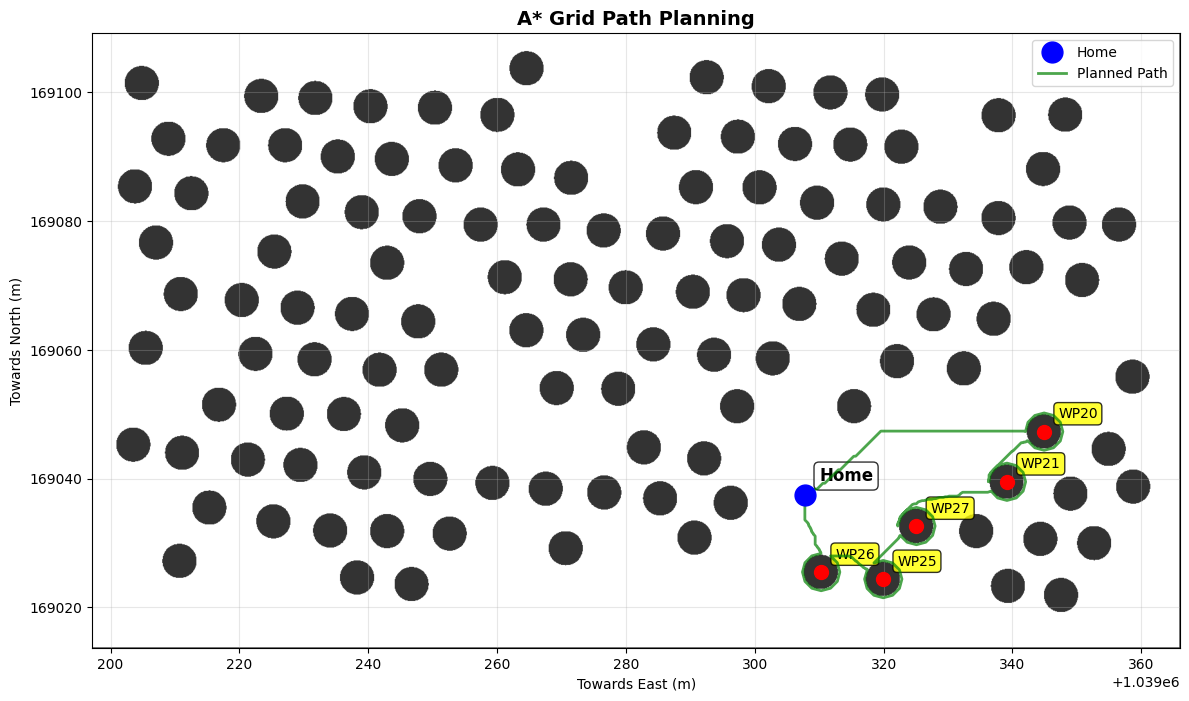

Global path has 486 waypoints


In [34]:
site_path = "sample_data3/"  # *CHANGE HERE* for different sample data
map_path = site_path + "occupancy_map.png"
img_path = site_path + "random_oilpalm.tif"
crowns_path = site_path + "crowns_exported.gpkg"
occupancy_resolution = 0.1 # in m
vehicle_radius = 0.3 # in m
palm_oil_tree_radius = 0.5 # in m
orbital_radius = 1.0 # in m
inflated_obstacle = (vehicle_radius + palm_oil_tree_radius) * 2 + orbital_radius
orbit_radius = inflated_obstacle + 3 * occupancy_resolution
print(f"Orbit radius: {orbit_radius} m")
print(f"Inflated obstacle size: {inflated_obstacle} m")

# Waypoint configuration
# home = (1.954826, 103.214203) # sample 1
# home = (1.426639, 103.644381) # sample 2
home = (1.523838, 103.842520) # sample 3

# List of crown IDs to visit
visit_ids = [20, 21, 25, 26, 27]

# Drone parameters
drone_speed = 1.5        # meters per second
max_flight_time = 480.0  # seconds
max_distance = drone_speed * max_flight_time  # meters

# Setup environment
georef_map, world_coords = setup_path_planning_environment(
    img_path, crowns_path, map_path, home, visit_ids
)

if georef_map is not None:
    # Solve TSP
    tsp_order = solve_tsp_with_ortools(world_coords, visit_ids, max_distance)
    
    # Plan path with A*
    astar_planner = AStarGrid(georef_map, allow_diagonal=True, orbit_radius=orbit_radius, orbit_points=12)
    global_path = astar_planner.plan_global_path(
        world_coords[0], world_coords, tsp_order
    )
    
    # Plot results
    plot_path_on_map(georef_map, world_coords, visit_ids, 
                    global_path, "A* Grid Path Planning")
    
    print(f"Global path has {len(global_path)} waypoints")

### Export to CSV

In [35]:
import csv

site_path = "sample_data3/" # *CHANGE HERE* for different sample data
img_path = site_path + "random_oilpalm.tif"
local_path_csv = site_path + "astar_local_path.csv"
latlon_path_csv = site_path + "astar_latlon_path.csv"

# convert to local coordinates
gx0, gy0 = global_path[0]
local_path = [(x - gx0, y - gy0) for x, y in global_path]
with rasterio.open(img_path) as src:
    utm_crs = src.crs

# convert to lat/lon coordinates
transformer = pyproj.Transformer.from_crs(utm_crs, "EPSG:4326", always_xy=True)  # Web Mercator
latlon_path = [transformer.transform(x, y) for x, y in global_path]  # (lon, lat)

with open(local_path_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['x_local', 'y_local'])
    writer.writerows(local_path)

with open(latlon_path_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['longitude', 'latitude'])
    writer.writerows(latlon_path)

print(f"Local path saved to {local_path_csv}")
print(f"Lat/Lon path saved to {latlon_path_csv}")

Local path saved to sample_data3/astar_local_path.csv
Lat/Lon path saved to sample_data3/astar_latlon_path.csv


### Visualize

In [36]:
site_path = "sample_data3/" # *CHANGE HERE* for different sample data
local_path_csv = site_path + "astar_local_path.csv"
latlon_path_csv = site_path + "astar_latlon_path.csv"
img_path = site_path + "random_oilpalm.tif"
crowns_path = site_path + "crowns_exported.gpkg"
overlay_img_path = site_path + "overlay_rgb.png"

# home = (1.954826, 103.214203) # sample 1
# home = (1.426639, 103.644381) # sample 2
home = (1.523838, 103.842520) # sample 3

# List of crown IDs to visit
visit_ids = [0, 20, 21, 25, 26, 27, 0] # need to add home at the start and end

In [37]:
# Visualization
import asyncio
import rasterio
import numpy as np
import geopandas as gpd 
import pandas as pd
from PIL import Image
from shapely.geometry import box, mapping, shape
from shapely.ops import transform
import pyproj

from ipyleaflet import (
    Map, GeoJSON, Marker, LayerGroup, DivIcon, AwesomeIcon,
    basemap_to_tiles, basemaps, ImageOverlay, LayersControl, TileLayer,
    MarkerCluster, Polyline
)
from ipywidgets import Button, Layout

def save_rgb_overlay_as_png(img_path, output_img="overlay.png"):
    with rasterio.open(img_path) as src:
        img = src.read()
        bounds = src.bounds
        crs = src.crs
        
        if img.shape[0] >= 3:
            rgb = np.stack([img[0], img[1], img[2]], axis=-1)
        else:
            raise ValueError("Need at least 3 bands for RGB")
        
        # Normalize for better display
        rgb = rgb.astype(np.float32)
        rgb_min, rgb_max = np.percentile(rgb[rgb > 0], (2, 98))
        rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)
        rgb = (rgb * 255).astype(np.uint8)
        
        image = Image.fromarray(rgb)
        image.save(output_img)
        
        return output_img, bounds, crs

overlay_img_path, utm_bounds, utm_crs = save_rgb_overlay_as_png(img_path, output_img=overlay_img_path)

def reproject_bounds_to_wgs84(bounds, src_crs):
    project = pyproj.Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True).transform
    return transform(project, box(*bounds)).bounds

wgs84_bounds = reproject_bounds_to_wgs84(utm_bounds, utm_crs)
lon_min, lat_min, lon_max, lat_max = wgs84_bounds

crowns = gpd.read_file(crowns_path)
if crowns.crs != "EPSG:4326":
    crowns = crowns.to_crs("EPSG:4326")
crowns["id"] = crowns.index
crowns_json = crowns.__geo_interface__

for i, feat in enumerate(crowns_json["features"]):
    feat["id"] = i

center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

m = Map(center=(center_lat, center_lon), zoom=18, max_zoom=20)
m.layout.width = '100%'
m.layout.height = '900px'

google_sat = TileLayer(
    url="http://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attribution="Google Satellite",
    name="Google Satellite",
    max_zoom=20
)
m.add_layer(google_sat)

esri_sat = basemap_to_tiles(basemaps.Esri.WorldImagery)
esri_sat.name = "ESRI Imagery"
m.add_layer(esri_sat)

overlay = ImageOverlay(
    url=overlay_img_path,
    bounds=[(lat_min, lon_min), (lat_max, lon_max)],
    opacity=0.6,
    name="Oil Palm RGB"
)
m.add_layer(overlay)

m.add_control(LayersControl(position="topright"))

crown_id_layer = LayerGroup(name="Crown IDs")
m.add_layer(crown_id_layer)

for feature in crowns_json['features']:
    crown_id = feature['id']
    geometry = feature['geometry']
    if geometry['type'] == 'Polygon':
        polygon = shape(geometry)
        centroid = polygon.centroid
        icon = DivIcon(
                icon_size=(20, 20),
                icon_anchor=(10, 10),
            )
        if crown_id in visit_ids:
            if crown_id == visit_ids[-1]:
                icon.html = f"<div style='color: #ffffff; font-size: 12px; text-align: center; text-shadow: -1px -1px 0 black, 1px -1px 0 black, -1px 1px 0 black, 1px 1px 0 black;'>{crown_id}</div>"
            else:
                icon.html=f"<div style='color: darkblue; font-size: 12px; font-weight: bold; text-align: center; text-shadow: -1px -1px 0 blue, 1px -1px 0 blue, -1px 1px 0 blue, 1px 1px 0 blue;'>{crown_id}</div>"
        else:
            icon.html = f"<div style='color: #ffffff; font-size: 12px; text-align: center; text-shadow: -1px -1px 0 black, 1px -1px 0 black, -1px 1px 0 black, 1px 1px 0 black;'>{crown_id}</div>"
        marker = Marker(location=(centroid.y, centroid.x), icon=icon, draggable=False)
        crown_id_layer.add_layer(marker)

# Create GeoJSON with appropriate settings to prevent layer issues
crown_layer = GeoJSON(
    data=crowns_json,
    name="Tree Crowns",
    hover_style={"fillColor": "red", "fillOpacity": 0.5},
    style={"fillOpacity": 0.3, "color": "yellow", "weight": 0.5},
    click_events=True 
)
m.add_layer(crown_layer)

try:
    df_path = pd.read_csv(latlon_path_csv)

    latlon_path = df_path[['latitude', 'longitude']].values.tolist()
except FileNotFoundError:
    print("Error: 'latlon_path.csv' not found. Please check the file path.")

# Vehicle icon
quad_icon = AwesomeIcon(
    name='fighter-jet',
    marker_color="black",
    icon_color='white',
    icon_size=[30, 30],
    icon_anchor=[15, 15]
)

if latlon_path:
    print(f"Drone route has {len(latlon_path)} waypoints")
    # print(f"Drone route: {latlon_path}")
    print(f"Drone home: {latlon_path[0]}")
    animated_marker = Marker(location=latlon_path[0], icon=quad_icon)
    animated_line = Polyline(locations=[latlon_path[0]], color="red", fill=False, weight=4)

    animation_layer = LayerGroup(name="Drone Route")
    animation_layer.add_layer(animated_marker)
    animation_layer.add_layer(animated_line)
    m.add_layer(animation_layer)

    async def animate_route(marker, polyline, route, delay=0.1):
        for coord in route[1:]:
            await asyncio.sleep(delay)
            marker.location = coord
            polyline.locations = polyline.locations + [coord]

    start_button = Button(
        description="Start Drone Animation",
        layout=Layout(width='220px', height='40px', margin='10px 0px 10px 10px'),
        style={'button_color': "#1fb49b", 'font_weight': 'bold', 'font_size': '14px'}
    )

    def on_start_click(b):
        start_button.disabled = False
        loop = asyncio.get_event_loop()
        loop.create_task(animate_route(animated_marker, animated_line, latlon_path, delay=0.1))

    start_button.on_click(on_start_click)

    display(start_button)
else:
    print("No path data available for animation.")

display(m)

Drone route has 486 waypoints
Drone home: [1.523838, 103.84252]


Button(description='Start Drone Animation', layout=Layout(height='40px', margin='10px 0px 10px 10px', width='2…

Map(center=[1.5240548772462368, 103.8422855317323], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [ ]:
print(f"Center latlon of the map: {center_lat:.6f}, {center_lon:.6f}")
print(f"Home position in lat/lon: {home[0]:.6f}, {home[1]:.6f}")
local_offset_x = home[1] - center_lon
local_offset_y = home[0] - center_lat
print(f"Local offset in degrees: ({local_offset_x:.6f}, {local_offset_y:.6f})")
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)  # Web Mercator

local_offset_x_in_m, local_offset_y_in_m = transformer.transform(local_offset_x, local_offset_y)  # Convert degrees to meters
print(f"Local offset in meters: ({local_offset_x_in_m:.6f} m, {local_offset_y_in_m:.6f})")

center_lat: 1.524055, center_lon: 103.842286
Home position in lat/lon: 1.523838, 103.842520
Local offset in degrees: (0.000234, -0.000217)
Local offset in meters: (26.100888 m, -24.142665)


## Post Waypoint Processing

In [39]:
even_local_path_csv = site_path + "astar_evenly_spaced_local_path.csv"
overlap_tolerance = 0.1  # meters

Original path points: 486
Evenly spaced path points (with state): 67
Spacing statistics - Mean: 2.44m, Std: 2.60m, Min: 0.10m, Max: 10.00m
Local coordinates with state exported to: sample_data3/astar_evenly_spaced_local_path.csv


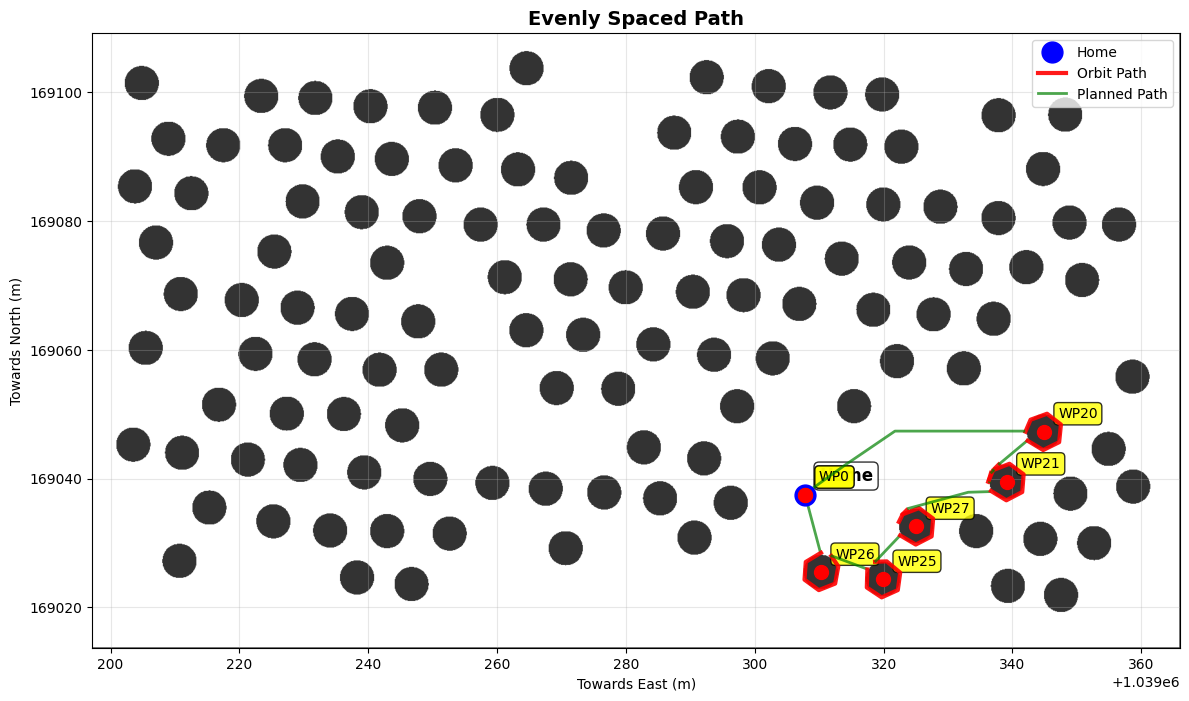

In [40]:
import numpy as np
import math
from typing import List, Tuple, Dict
import csv

def calculate_distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    """Calculate Euclidean distance between two points"""
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def interpolate_point(p1: Tuple[float, float], p2: Tuple[float, float], ratio: float) -> Tuple[float, float]:
    """Interpolate point between p1 and p2 at given ratio (0.0 to 1.0)"""
    x = p1[0] + ratio * (p2[0] - p1[0])
    y = p1[1] + ratio * (p2[1] - p1[1])
    return (x, y)

def identify_orbit_segments(global_path: List[Tuple[float, float]],
                          world_coords: Dict[int, Tuple[float, float]],
                          orbit_radius: float = 2.5,
                          tolerance: float = 0.5) -> List[Tuple[int, int]]:
    """
    Identify orbit segments in the global path.
    Returns list of (start_idx, end_idx) tuples for each orbit segment.
    """
    orbit_segments = []
    current_segment_start = None

    if not global_path:
        return []

    for i, point in enumerate(global_path):
        is_orbit_point = False

        # Check if this point is close to any waypoint center (within orbit radius + tolerance)
        for waypoint_id, waypoint_center in world_coords.items():
            if waypoint_id == 0:  # Skip home position
                continue

            dist_to_center = calculate_distance(point, waypoint_center)
            if abs(dist_to_center - orbit_radius) <= tolerance:
                is_orbit_point = True
                break

        if is_orbit_point:
            if current_segment_start is None:
                current_segment_start = i
        else:
            if current_segment_start is not None:
                # End of orbit segment
                # Ensure segment has at least one point. If start=i, it means previous point was last orbit point.
                if i > current_segment_start :
                    orbit_segments.append((current_segment_start, i - 1))
                else: # Single point orbit detection, or end of path
                     orbit_segments.append((current_segment_start, current_segment_start))
                current_segment_start = None

    # Handle case where path ends with orbit
    if current_segment_start is not None:
        orbit_segments.append((current_segment_start, len(global_path) - 1))

    return orbit_segments

def create_evenly_spaced_segment(path_segment: List[Tuple[float, float]],
                               spacing: float,
                               traverse_state: str) -> List[Tuple[float, float, str]]:
    """
    Create evenly spaced points along a path segment.
    Each point is returned as (x, y, state).
    """
    if not path_segment:
        return []
    
    # If only one point in the segment, return it with its state
    if len(path_segment) == 1:
        return [(path_segment[0][0], path_segment[0][1], traverse_state)]

    # Calculate cumulative distances along the segment
    cumulative_distances = [0.0]
    for i in range(1, len(path_segment)):
        dist = calculate_distance(path_segment[i-1], path_segment[i])
        cumulative_distances.append(cumulative_distances[-1] + dist)

    total_distance = cumulative_distances[-1]

    # If the segment is essentially a single point (or points are too close)
    if total_distance < 1e-9: # Using a small epsilon for float comparison
        return [(path_segment[0][0], path_segment[0][1], traverse_state)]

    # If total distance is less than the target spacing, but points are distinct,
    # return only the start and end points of this original segment.
    if total_distance < spacing:
        return [
            (path_segment[0][0], path_segment[0][1], traverse_state),
            (path_segment[-1][0], path_segment[-1][1], traverse_state)
        ]

    # Generate evenly spaced points
    # Always include the start point of the segment with its state
    spaced_points_with_state = [(path_segment[0][0], path_segment[0][1], traverse_state)]

    current_interp_distance = spacing
    while current_interp_distance < total_distance:
        # Find which original sub-segment this distance falls into
        for i in range(len(cumulative_distances) - 1):
            if cumulative_distances[i] <= current_interp_distance < cumulative_distances[i + 1]:
                # Interpolate within this sub-segment
                segment_start_dist = cumulative_distances[i]
                # segment_end_dist = cumulative_distances[i + 1] # Not directly needed for ratio
                segment_length = calculate_distance(path_segment[i], path_segment[i+1]) # Length of current sub-segment

                if segment_length > 1e-9: # Avoid division by zero if points are identical
                    ratio = (current_interp_distance - segment_start_dist) / segment_length
                    # Ensure ratio is within [0,1] due to potential floating point inaccuracies
                    ratio = max(0.0, min(1.0, ratio))
                    interpolated_point_coords = interpolate_point(path_segment[i], path_segment[i + 1], ratio)
                    spaced_points_with_state.append((interpolated_point_coords[0], interpolated_point_coords[1], traverse_state))
                # If segment_length is near zero, it implies path_segment[i] and path_segment[i+1] are coincident.
                # In this case, we effectively skip adding a new point for this current_interp_distance
                # if it falls exactly on such a zero-length segment, as the start point of the next
                # non-zero length segment or the final end point will cover it.
                break
        current_interp_distance += spacing

    # Always include the end point of the segment, ensuring it's the exact original end point
    last_original_point_coords = path_segment[-1]
    # Check if the last point added is different from the original segment's end point
    if not spaced_points_with_state or \
       calculate_distance((spaced_points_with_state[-1][0], spaced_points_with_state[-1][1]), last_original_point_coords) > 1e-6:
        spaced_points_with_state.append((last_original_point_coords[0], last_original_point_coords[1], traverse_state))
    else:
        # If it's very close, ensure the state is correct and it's the exact point coordinates
        spaced_points_with_state[-1] = (last_original_point_coords[0], last_original_point_coords[1], traverse_state)
        
    return spaced_points_with_state


def generate_evenly_spaced_path(global_path: List[Tuple[float, float]],
                              world_coords: Dict[int, Tuple[float, float]],
                              target_spacing: float = 5.0,
                              orbit_target_spacing: float = 2.0,
                              orbit_radius: float = 2.5) -> List[Tuple[float, float, str]]:
    """
    Generate evenly spaced path with preserved orbit start/end points and state.
    Returns: List of (x, y, state) tuples.
    """
    if not global_path:
        return []

    # Handle single-point path case
    if len(global_path) == 1:
        point = global_path[0]
        is_orbit_pt = False
        for waypoint_id, waypoint_center in world_coords.items():
            if waypoint_id == 0: continue
            if abs(calculate_distance(point, waypoint_center) - orbit_radius) <= overlap_tolerance: # Using tolerance
                is_orbit_pt = True
                break
        state = "Orbit" if is_orbit_pt else "Normal"
        return [(point[0], point[1], state)]

    orbit_segments_indices = identify_orbit_segments(global_path, world_coords, orbit_radius, overlap_tolerance) # Using tolerance
    # print(f"Identified {len(orbit_segments_indices)} orbit segments: {orbit_segments_indices}")

    final_path_with_states: List[Tuple[float, float, str]] = []
    current_global_path_idx = 0 # Tracks the start index for the next segment to process from global_path

    for orbit_start_idx, orbit_end_idx in orbit_segments_indices:
        # 1. Process segment BEFORE this orbit (Normal state)
        if current_global_path_idx < orbit_start_idx:
            normal_segment_to_process = global_path[current_global_path_idx : orbit_start_idx]
            if normal_segment_to_process:
                spaced_normal_part = create_evenly_spaced_segment(normal_segment_to_process, target_spacing, "Normal")
                
                # Append, handling potential overlap with the last point of final_path_with_states
                if final_path_with_states and spaced_normal_part and calculate_distance((final_path_with_states[-1][0], final_path_with_states[-1][1]), (spaced_normal_part[0][0], spaced_normal_part[0][1])) < 1e-6:
                    final_path_with_states.extend(spaced_normal_part[1:])
                elif spaced_normal_part: # Avoid extending if spaced_normal_part is empty
                    final_path_with_states.extend(spaced_normal_part)

        # 2. Process the ORBIT segment itself (Orbit state)
        # This segment is global_path[orbit_start_idx ... orbit_end_idx]
        orbit_segment_to_process = global_path[orbit_start_idx : orbit_end_idx + 1]
        if orbit_segment_to_process:
            spaced_orbit_part = create_evenly_spaced_segment(orbit_segment_to_process, orbit_target_spacing, "Orbit")

            # Append, handling potential overlap.
            if final_path_with_states and spaced_orbit_part and calculate_distance((final_path_with_states[-1][0], final_path_with_states[-1][1]), (spaced_orbit_part[0][0], spaced_orbit_part[0][1])) < 1e-6:
                final_path_with_states[-1] = (final_path_with_states[-1][0], final_path_with_states[-1][1], "Normal")
                final_path_with_states.extend(spaced_orbit_part[1:])
            elif spaced_orbit_part: # Avoid extending if spaced_orbit_part is empty
                final_path_with_states.extend(spaced_orbit_part)
        
        current_global_path_idx = orbit_end_idx + 1

    # 3. Process any remaining segment AFTER the last orbit (Normal state)
    if current_global_path_idx < len(global_path):
        remaining_segment_to_process = global_path[current_global_path_idx:]
        if remaining_segment_to_process:
            spaced_remaining_part = create_evenly_spaced_segment(remaining_segment_to_process, target_spacing, "Normal")
            
            if final_path_with_states and spaced_remaining_part and \
               calculate_distance((final_path_with_states[-1][0], final_path_with_states[-1][1]), (spaced_remaining_part[0][0], spaced_remaining_part[0][1])) < 1e-6:
                final_path_with_states.extend(spaced_remaining_part[1:])
            elif spaced_remaining_part: # Avoid extending if spaced_remaining_part is empty
                final_path_with_states.extend(spaced_remaining_part)
    
    # If no orbit segments were found, the entire path is processed as normal.
    if not orbit_segments_indices and global_path and not final_path_with_states:
        final_path_with_states = create_evenly_spaced_segment(global_path, target_spacing, "Normal")

    return final_path_with_states


def export_evenly_spaced_path(global_path: List[Tuple[float, float]],
                            world_coords: Dict[int, Tuple[float, float]],
                            even_local_path_csv: str = "evenly_spaced_local_path.csv", # Added parameter with default
                            orbit_target_spacing: float = 2.0,
                            target_spacing: float = 5.0,
                            orbit_radius: float = 2.5):
    """
    Generates an evenly spaced path, exports local coordinates with state to CSV.
    """
    # Generate evenly spaced path with states
    evenly_spaced_path_with_states = generate_evenly_spaced_path(
        global_path, world_coords, target_spacing, orbit_target_spacing, orbit_radius
    )

    print(f"Original path points: {len(global_path)}")
    print(f"Evenly spaced path points (with state): {len(evenly_spaced_path_with_states)}")

    # Calculate actual spacings for verification
    spacings = []
    for i in range(1, len(evenly_spaced_path_with_states)):
        p1_coords = (evenly_spaced_path_with_states[i-1][0], evenly_spaced_path_with_states[i-1][1])
        p2_coords = (evenly_spaced_path_with_states[i][0], evenly_spaced_path_with_states[i][1])
        dist = calculate_distance(p1_coords, p2_coords)
        spacings.append(dist)

    if spacings:
        print(f"Spacing statistics - Mean: {np.mean(spacings):.2f}m, "
              f"Std: {np.std(spacings):.2f}m, "
              f"Min: {np.min(spacings):.2f}m, "
              f"Max: {np.max(spacings):.2f}m")
    else:
        print("No spacings to calculate (path has 0 or 1 point).")

    # Export local coordinates with state
    gx0, gy0, _ = evenly_spaced_path_with_states[0] # Unpack, state of first point not used for origin
    
    # Create list of (local_x, local_y, state)
    local_path_with_states = [(x - gx0, y - gy0, state) for x, y, state in evenly_spaced_path_with_states]

    with open(even_local_path_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['x_local', 'y_local', 'state']) # CSV Header
        writer.writerows(local_path_with_states) # Write data rows

    print(f"Local coordinates with state exported to: {even_local_path_csv}")

    return evenly_spaced_path_with_states

# Distribute waypoint path evenly
evenly_spaced_path = export_evenly_spaced_path(
    global_path=global_path,
    world_coords=world_coords,
    even_local_path_csv=even_local_path_csv,
    orbit_target_spacing=astar_planner.orbit_radius,
    target_spacing=10.0,
    orbit_radius=astar_planner.orbit_radius
)

if evenly_spaced_path:
    plot_path_on_map(georef_map, world_coords, visit_ids, 
                    path=evenly_spaced_path, 
                    title="Evenly Spaced Path")